### Import libraries

In [133]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [134]:
#reading dataset
exchange_data = pd.read_csv('dataset/usd_pkr_records.csv')
exchange_data.head()


,Date,Price,Open,High,Low,Vol.,Change %
0,03/22/2023,283.125,284.125,284.125,279.50,0.03K,0.73%
1,03/21/2023,281.060,284.500,284.500,279.63,0.02K,-0.06%
2,03/20/2023,281.220,278.250,284.625,278.25,0.05K,-0.10%
3,03/17/2023,281.500,282.875,283.375,278.13,0.02K,-0.53%
4,03/16/2023,283.000,282.875,283.375,278.75,0.02K,0.00%


In [135]:
exchange_data["Date"] = pd.to_datetime(exchange_data["Date"])
ind_exchange_data = exchange_data.set_index(["Date"], drop=True)

In [136]:
#checking first few records of the dataset
ind_exchange_data.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2023-03-22,283.125,284.125,284.125,279.50,0.03K,0.73%
2023-03-21,281.060,284.500,284.500,279.63,0.02K,-0.06%
2023-03-20,281.220,278.250,284.625,278.25,0.05K,-0.10%
2023-03-17,281.500,282.875,283.375,278.13,0.02K,-0.53%
2023-03-16,283.000,282.875,283.375,278.75,0.02K,0.00%


In [137]:
# sorting the dataset in ascending order of date
data_frame = ind_exchange_data.sort_index(axis=1 ,ascending=True)
data_frame = data_frame.iloc[::-1]
data_frame.head()

,Change %,High,Low,Open,Price,Vol.
Date,,,,,,
2019-01-01,0.00%,139.80,139.80,139.80,139.80,0.11K
2019-01-02,0.04%,140.05,138.30,139.75,139.85,0.16K
2019-01-03,0.00%,140.04,138.35,139.85,139.85,1.50K
2019-01-04,0.00%,140.00,135.37,139.85,139.85,1.92K
2019-01-05,0.00%,139.85,139.85,139.85,139.85,NaN


<Axes: xlabel='Date'>

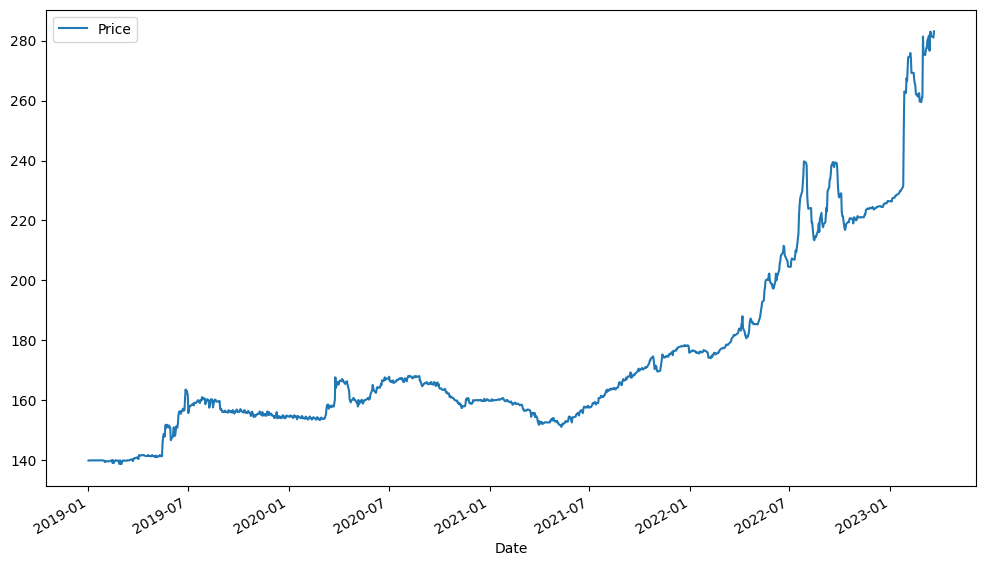

In [138]:
df = data_frame[["Price"]]

#plotting dataset to visualize the pattern of prices over the years

df.plot(kind='line',figsize=(12,7))

Now, checking total data in the dataset in terms of years and further check 80% of the dataset lies within which interval

In [139]:
diff = df.index.values[-1] - df.index.values[0]
days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("80 percent data = 2019 to %d"%(2019 + int(0.8*years)))

Total data: 4 years
80 percent data = 2019 to 2022


### Summary Statistics

In [140]:
df.describe()

,Price
count,1184.000000
mean,172.745097
std,30.368351
min,138.625000
25%,154.987500
50%,160.275000
75%,176.725000
max,283.125000


### Train Test Split

As we have seen 80% of the data lies in the interval of 2010 and 2018 so we will train the model for the date range of **26 August 2010 to 26 August 2018** and rest will be used as the testing data

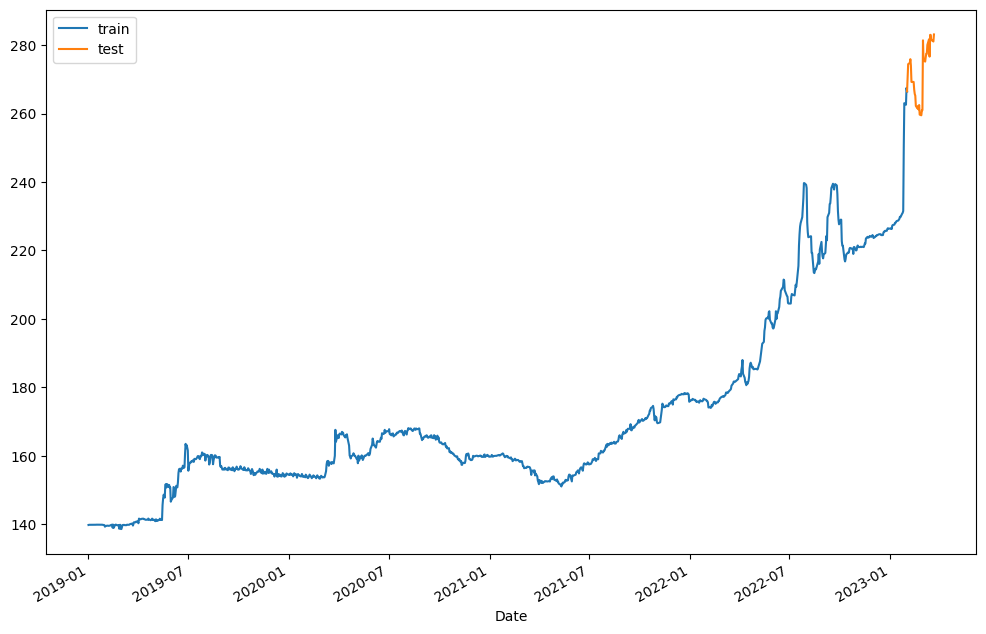

In [141]:
split_date = pd.Timestamp('2023-02-01')

train = df.loc[:split_date]
test = df.loc[split_date:]

ax = train.plot(kind='line',figsize=(12,8))
test.plot(ax=ax,kind='line',figsize=(12,8))
plt.legend(['train', 'test'])

### Data Normalization

In [142]:
from sklearn.preprocessing import StandardScaler

In [143]:
sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [144]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [145]:
X_train

array([[-1.18443713],
       [-1.18245783],
       [-1.18245783],
       ...,
       [ 3.69454261],
       [ 3.67672889],
       [ 3.8707005 ]])

### Data preprocessing for GRU

In [146]:
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

### GRU

In [147]:
from keras.layers import GRU
K.clear_session()
model_gru = Sequential()
model_gru.add(GRU(7, input_shape=(1, X_train.shape[1]), activation='linear', kernel_initializer='lecun_uniform', return_sequences=False))
model_gru.add(Dense(1))
model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 7)                 210       
                                                                 
 dense (Dense)               (None, 1)                 8         
                                                                 
Total params: 218
Trainable params: 218
Non-trainable params: 0
_________________________________________________________________


In [148]:
model_gru.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
history_model_gru = model_gru.fit(X_tr_t, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
1148/1148 [==============================] - 3s 2ms/step - loss: 0.0070 - rmse: 0.0840
Epoch 2/100
1148/1148 [==============================] - 2s 2ms/step - loss: 0.0038 - rmse: 0.0613
Epoch 3/100
1148/1148 [==============================] - 2s 2ms/step - loss: 0.0038 - rmse: 0.0617
Epoch 4/100
1148/1148 [==============================] - 2s 2ms/step - loss: 0.0032 - rmse: 0.0568
Epoch 5/100
1148/1148 [==============================] - 2s 2ms/step - loss: 0.0032 - rmse: 0.0564
Epoch 6/100
1148/1148 [==============================] - 2s 2ms/step - loss: 0.0031 - rmse: 0.0556
Epoch 7/100
1148/1148 [==============================] - 2s 2ms/step - loss: 0.0030 - rmse: 0.0547
Epoch 8/100
1148/1148 [==============================] - 2s 2ms/step - loss: 0.0030 - rmse: 0.0543
Epoch 9/100
1148/1148 [==============================] - 3s 2ms/step - loss: 0.0029 - rmse: 0.0543
Epoch 10/100
1148/1148 [==============================] - 2s 2ms/step - loss: 0.0030 - rmse: 0.0545
Epoch 11/

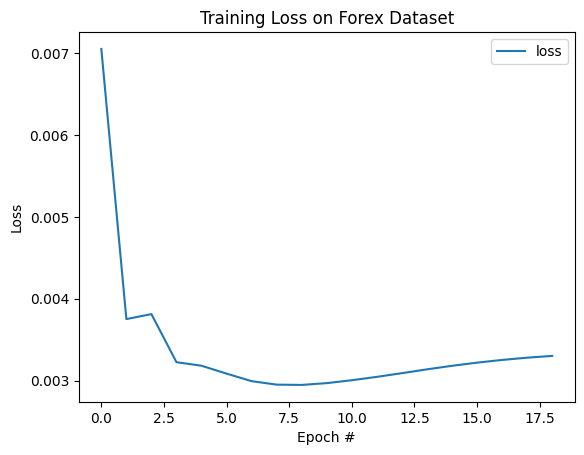

In [151]:
N = 19

plt.figure()

plt.plot(np.arange(0, N), history_model_gru.history["loss"], label="loss")
plt.title("Training Loss on Forex Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

### GRU Prediction

In [ ]:


y_pred_test_gru = model_gru.predict(X_tst_t)
y_train_pred_gru = model_gru.predict(X_tr_t)

train_mse = metrics.mean_squared_error(y_train, y_train_pred_gru)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(y_test, y_pred_test_gru)
rmse_test = np.sqrt(test_mse)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_gru)))
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred_gru)))

print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
r2_train = r2_score(y_train, y_train_pred_gru)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_gru)))
r2_test = r2_score(y_test, y_pred_test_gru)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test_gru)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

36/36 [==============================] - 0s 2ms/step
The R2 score on the Train set is:	0.991
The  MAE on the Train set is:	0.063
The  RMSE on the Train set is:	0.093
The Adjusted R2 score on the Train set is:	0.991

The R2 score on the Test set is:	0.692
The Adjusted R2 score on the Test set is:	0.683
The  MAE on the Test set is:	0.123
The  RMSE on the Test set is:	0.175


### GRU Prediction Plot

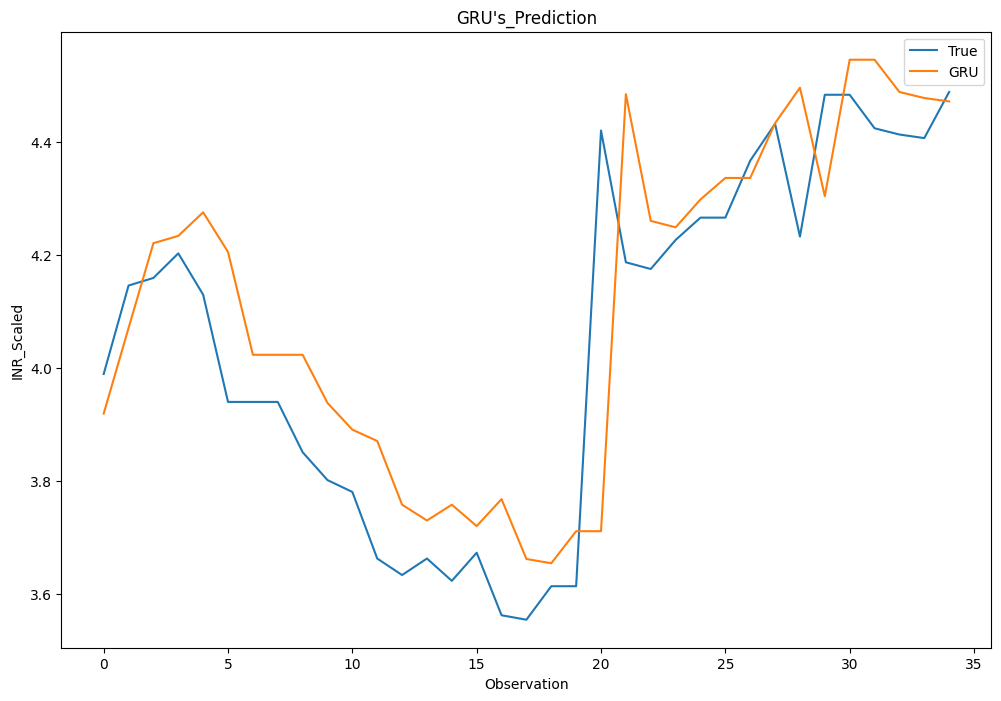

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_gru, label='GRU')
plt.title("GRU's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [ ]:
inv_yhat = sc.inverse_transform(y_pred_test_gru)

inv_yhat

array([[268.72604],
       [272.5575 ],
       [276.3556 ],
       [276.68198],
       [277.7382 ],
       [275.9621 ],
       [271.35968],
       [271.35968],
       [271.35968],
       [269.20477],
       [268.0081 ],
       [267.5008 ],
       [264.64923],
       [263.94125],
       [264.64923],
       [263.6925 ],
       [264.898  ],
       [262.21918],
       [262.02783],
       [263.46292],
       [263.46292],
       [283.02725],
       [277.35406],
       [277.06598],
       [278.31454],
       [279.27545],
       [279.27545],
       [281.72775],
       [283.31613],
       [278.45865],
       [284.56845],
       [284.56845],
       [283.12357],
       [282.85394],
       [282.6999 ]], dtype=float32)

In [ ]:
inv_ytest = sc.inverse_transform(y_test)

inv_ytest

array([[270.5  ],
       [274.46 ],
       [274.8  ],
       [275.9  ],
       [274.05 ],
       [269.25 ],
       [269.25 ],
       [269.25 ],
       [267.   ],
       [265.75 ],
       [265.22 ],
       [262.24 ],
       [261.5  ],
       [262.24 ],
       [261.24 ],
       [262.5  ],
       [259.7  ],
       [259.5  ],
       [261.   ],
       [261.   ],
       [281.4  ],
       [275.5  ],
       [275.2  ],
       [276.5  ],
       [277.5  ],
       [277.5  ],
       [280.05 ],
       [281.7  ],
       [276.65 ],
       [283.   ],
       [283.   ],
       [281.5  ],
       [281.22 ],
       [281.06 ],
       [283.125]])

In [ ]:
test_mse = metrics.mean_squared_error(inv_ytest, inv_yhat)
rmse_test = np.sqrt(test_mse)


print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(inv_ytest, inv_yhat)))
r2_test = r2_score(inv_ytest, inv_yhat)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(inv_ytest, inv_yhat)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

The R2 score on the Test set is:	0.692
The Adjusted R2 score on the Test set is:	0.683
The  MAE on the Test set is:	3.111
The  RMSE on the Test set is:	4.417


In [ ]:
test.head()

,Price
Date,
2023-02-01,266.50
2023-02-02,270.50
2023-02-03,274.46
2023-02-06,274.80
2023-02-07,275.90


In [ ]:
col1 = pd.DataFrame(inv_ytest, columns=['Price'])

col2 = pd.DataFrame(inv_yhat, columns=['GRU_prediction'])

col3 = pd.DataFrame(history_model_gru.history['rmse'], columns=['RMSE'])
results = pd.concat([col1, col2, col3], axis=1)
results.to_csv('Prediction_USD_INR_GRU.xlsx')

In [ ]:
results.head()

,Price,GRU_prediction,RMSE
0,270.50,268.726044,0.093978
1,274.46,272.557495,0.065107
2,274.80,276.355591,0.058037
3,275.90,276.681976,0.054688
4,274.05,277.738190,0.054763


In [ ]:
test.reset_index(level=0, inplace=True)
test.head()

,Date,Price
0,2023-02-01,266.50
1,2023-02-02,270.50
2,2023-02-03,274.46
3,2023-02-06,274.80
4,2023-02-07,275.90


In [ ]:
dfinal = test.merge(results, how='inner', left_on='Price', right_on='Price')

In [ ]:
dfinal.drop_duplicates(subset="Date",inplace=True)


dfinal.head()

,Date,Price,GRU_prediction,RMSE
0,2023-02-02,270.50,268.726044,0.093978
1,2023-02-03,274.46,272.557495,0.065107
2,2023-02-06,274.80,276.355591,0.058037
3,2023-02-07,275.90,276.681976,0.054688
4,2023-02-08,274.05,277.738190,0.054763


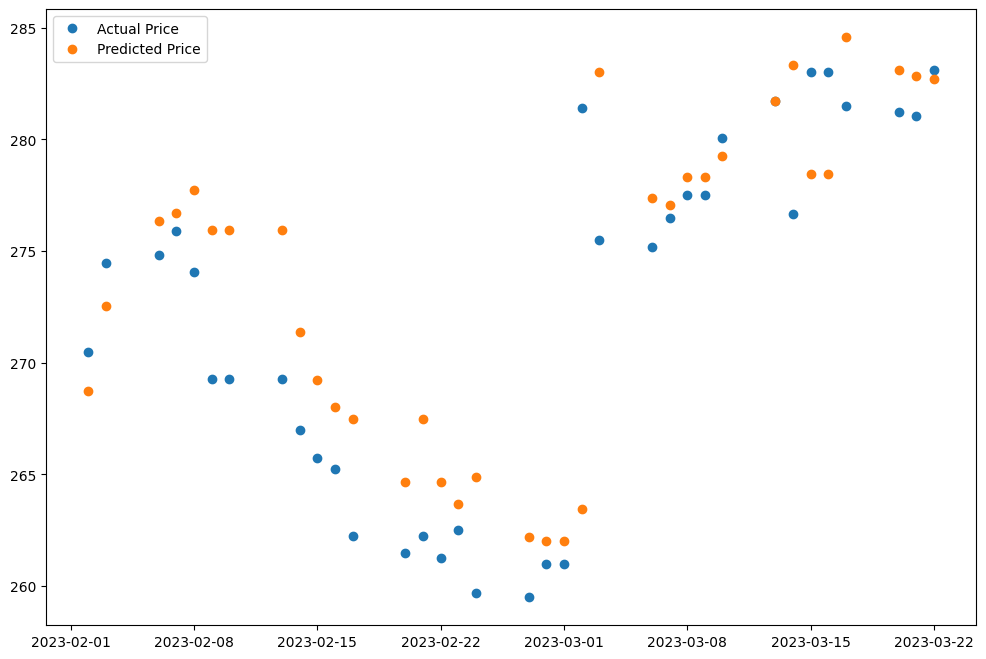

In [ ]:
plt.figure(figsize=(12,8))
price_date = dfinal['Date']
price_true = dfinal['Price']
price_pred = dfinal['GRU_prediction']
plt.plot_date(price_date, price_true,label='Actual Price')
plt.plot_date(price_date, price_pred,label='Predicted Price')
plt.legend()
plt.show()

In [ ]:
dfinal.describe()

,Price,GRU_prediction,RMSE
count,35.000000,35.000000,18.000000
mean,272.035857,273.705872,0.057992
std,8.080082,7.313184,0.009317
min,259.500000,262.027832,0.054447
25%,263.860000,267.500793,0.054640
50%,274.460000,275.962097,0.055014
75%,278.775000,278.458649,0.056142
max,283.125000,284.568451,0.093978


In [150]:
df_last = dfinal.tail(20)
df_last.head()
df_last.to_csv('checkpoints/predictions.csv', index=False)